# Убедимся в нестабильности одиночного дерева на своих данных


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
from matplotlib.pylab import rcParams

from IPython.core.pylabtools import figsize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
data = pd.read_csv('winequalityN.csv')
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()


data['type'] = labelencoder.fit_transform(data['type'])

for col in data.columns:
    mean = statistics.mean(data[col].dropna())
    data[col] = data[col].apply(lambda value: mean if pd.isnull(value) else value)

data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


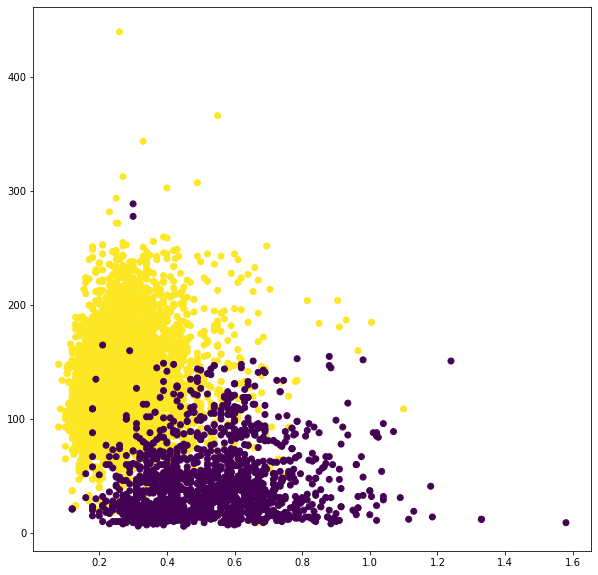

In [3]:
X = np.array(data[['volatile acidity','total sulfur dioxide']])
y = np.array(data["type"])

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0],X[:, 1], c=y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [4]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

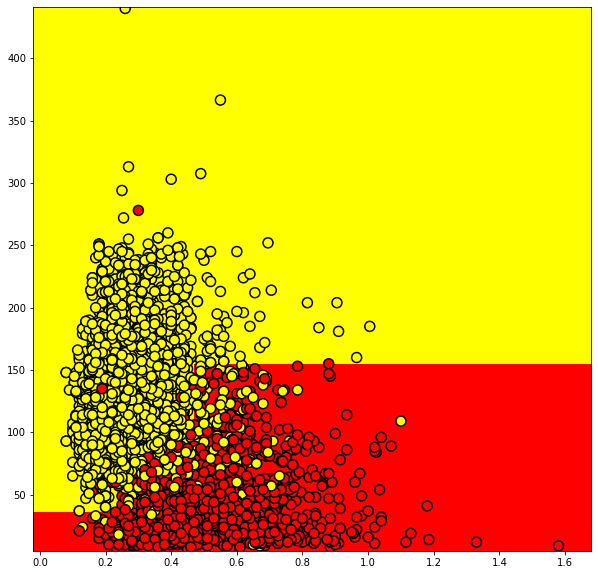

In [5]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(X_train)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X_train[:, 0],X_train[:, 1], c=y_train, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

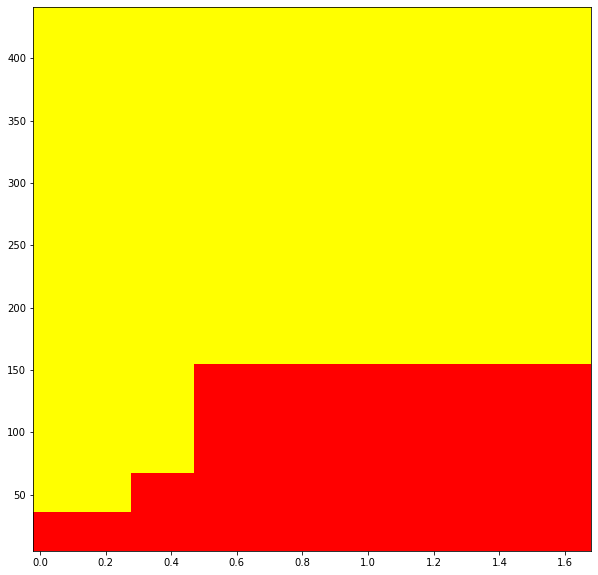

In [6]:
plt.figure(figsize=(10,10))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')

In [7]:
clf_tree.predict(np.array([[1,50]]))

array([0], dtype=int64)

In [8]:
clf_tree.predict(np.array([[1.4,250]]))

array([1], dtype=int64)

# Отберем важные признаки случайным лесом, сравним результат с отбором признаков линейным методом с $L_1$ - регуляризацией

In [9]:
X = np.array(data[data.columns[1:]])
y = np.array(data["type"])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

1	total sulfur dioxide	0.295895
2	chlorides           	0.257285
3	volatile acidity    	0.129714
4	density             	0.063937
5	residual sugar      	0.054131
6	sulphates           	0.052947
7	fixed acidity       	0.047302
8	free sulfur dioxide 	0.047225
9	pH                  	0.020720
10	citric acid         	0.017689
11	alcohol             	0.010412
12	quality             	0.002743


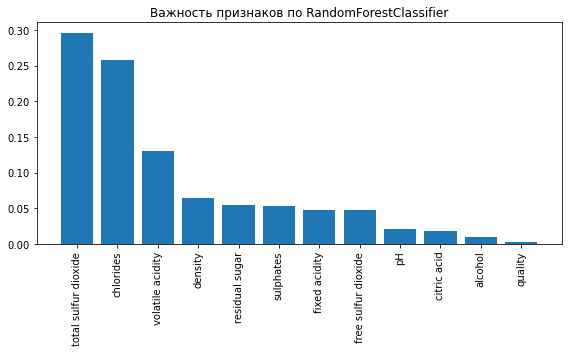

In [10]:
plt.rcParams['figure.figsize'] = (8,5)

from sklearn.ensemble import RandomForestClassifier
feat_labels = data.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print( "{}\t{: <20}\t{:.6f}".format(f+1, feat_labels[indices[f]], importances[indices[f]]) )
    
plt.title("Важность признаков по RandomForestClassifier")
plt.bar( range(X_train.shape[1]), importances[indices], align='center' )
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90);

plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Результаты показывают, что, возможно, 3 из 12 характеристик важны для прогнозирования (Вероятнее всего будут в начале дерева).

1	citric acid         	0.758794
2	alcohol             	0.712645
3	quality             	0.210969
4	residual sugar      	0.154441
5	total sulfur dioxide	0.062308
6	density             	0.002012
7	free sulfur dioxide 	-0.042936
8	chlorides           	-0.325545
9	fixed acidity       	-0.732858
10	sulphates           	-1.719161
11	pH                  	-1.763004
12	volatile acidity    	-2.455366


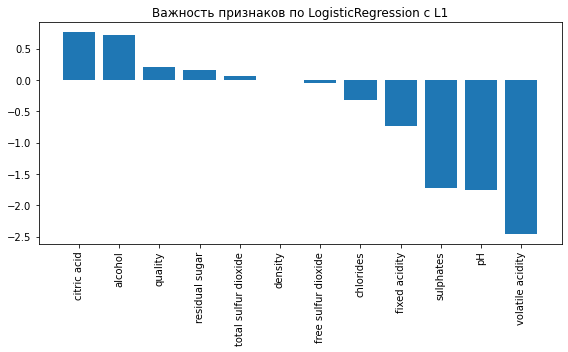

In [11]:
plt.rcParams['figure.figsize'] = (8,5)

feat_labels = data.columns[1:]
model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)

model.fit(X_train, y_train)

importance = model.coef_
indices = np.argsort(importance)[0][::-1]


for f in range(len(importance[0])):
    print("{}\t{: <20}\t{:.6f}".format(f+1, feat_labels[indices[f]], importance[0][indices[f]]) )
plt.title("Важность признаков по LogisticRegression с L1")
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.bar( range(X_train.shape[1]), importance[0][indices] )
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

В логистической же:
Положительные оценки указывают на функцию, которая предсказывает класс 1(белое вино), тогда как отрицательные оценки указывают на функцию, которая предсказывает класс 0(красное вино).

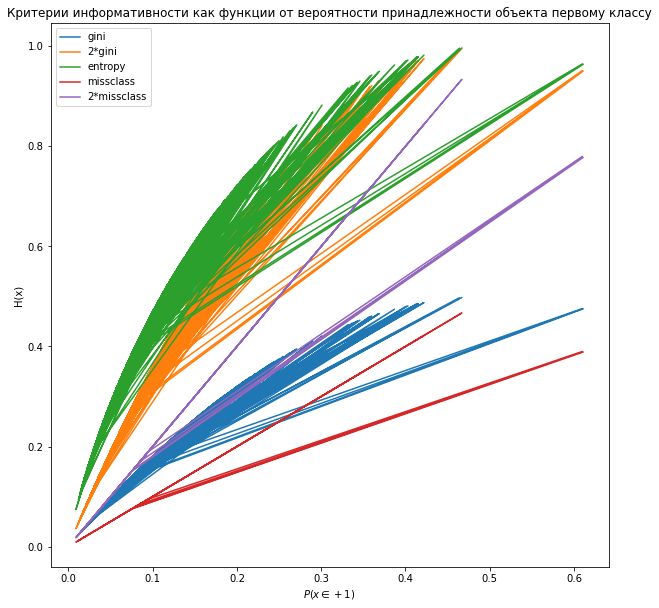

In [12]:
import math
plt.rcParams['figure.figsize'] = (10,10)
X = np.array(data[['chlorides','total sulfur dioxide']])
y = np.array(data["type"])

plt.plot(X[:, 0], [2 * x * (1-x) for x in X[:, 0]], label='gini')
plt.plot(X[:, 0], [4 * x * (1-x) for x in X[:, 0]], label='2*gini')
plt.plot(X[:, 0], [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in X[:, 0]], label='entropy')
plt.plot(X[:, 0], [1 - max(x, 1-x) for x in X[:, 0]], label='missclass')
plt.plot(X[:, 0], [2 - 2 * max(x, 1-x) for x in X[:, 0]], label='2*missclass')

plt.xlabel('$P(x \in +1)$')
plt.ylabel('H(x)')
plt.title('Критерии информативности как функции от вероятности принадлежности объекта первому классу')
plt.legend();

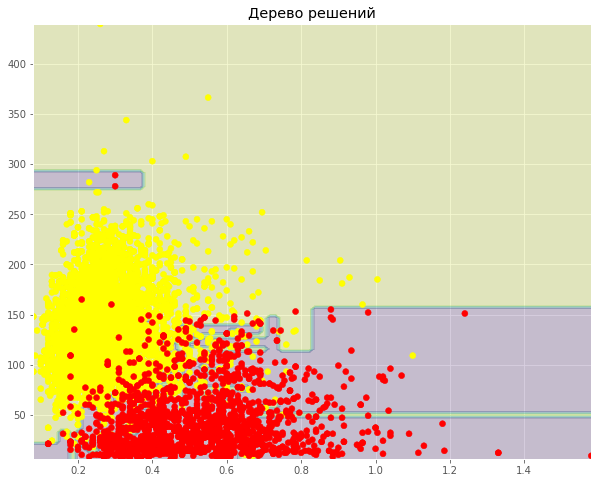

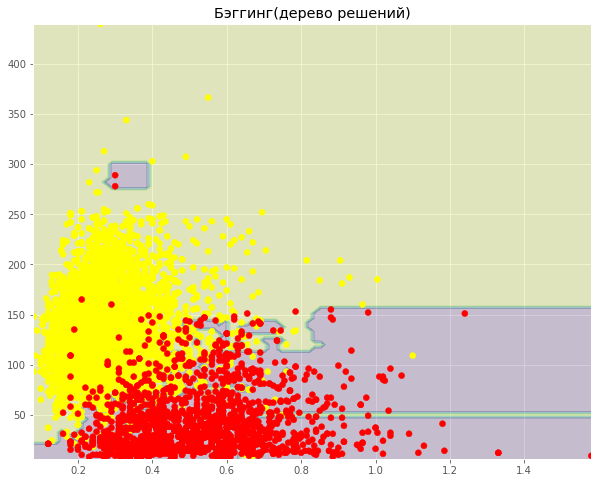

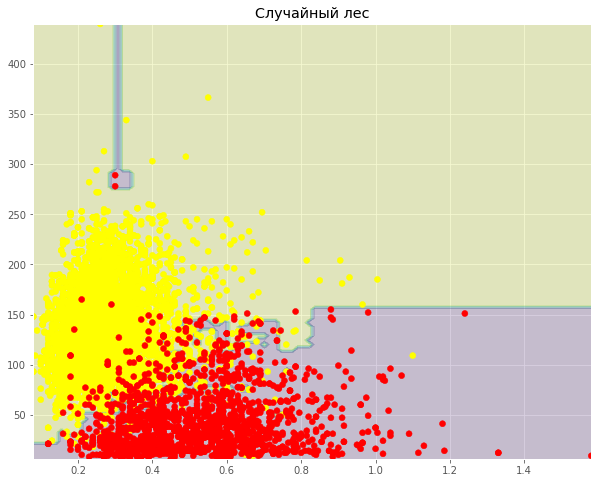

In [13]:
plt.style.use('ggplot')
%matplotlib inline

X = np.array(data[['volatile acidity','total sulfur dioxide']])
y = np.array(data["type"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel(), ])
y_hat = y_hat.reshape(xx1.shape)
plt.rcParams['figure.figsize'] = (10,8)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Дерево решений")
plt.show()

b_dtree = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, random_state=42)
b_dtree.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Бэггинг(дерево решений)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

In [14]:
from sklearn.model_selection import KFold
iis = KFold(n_splits=10)
print('Tree', '\t\tForest')

for ii, _ in iis.split(X_train):
    print(DecisionTreeClassifier().fit(X_train[ii, :], y_train[ii]).predict(np.array([[1, 125]])),
         end='\t\t')
    print(RandomForestClassifier().fit(X_train[ii, :], y_train[ii]).predict(np.array([[1, 125]])))

Tree 		Forest
[0]		[0]
[0]		[0]
[0]		[0]
[0]		[0]
[0]		[0]
[1]		[0]
[0]		[0]
[0]		[0]
[0]		[0]
[1]		[0]


In [15]:
from sklearn.metrics import roc_auc_score
print("Дерево:\t\t", roc_auc_score(y_test, dtree.predict(X_test)) )
print("Бэггинг:\t", roc_auc_score(y_test, b_dtree.predict(X_test)) )
print("Лес:\t\t", roc_auc_score(y_test, rf.predict(X_test)) )

Дерево:		 0.9284416818370541
Бэггинг:	 0.9309927022452174
Лес:		 0.937235316661876


In [16]:
print("Дерево:\t\t", roc_auc_score(y_train, dtree.predict(X_train)) )
print("Бэггинг:\t", roc_auc_score(y_train, b_dtree.predict(X_train)) )
print("Лес:\t\t", roc_auc_score(y_train, rf.predict(X_train)) )

Дерево:		 0.9958744610846381
Бэггинг:	 0.9927186152711595
Лес:		 0.9927186152711595


# Сравним качество работы случайного леса без кросс-валидации с кросс-валидацией

### Без кросс-валидации


0.9501538461538461


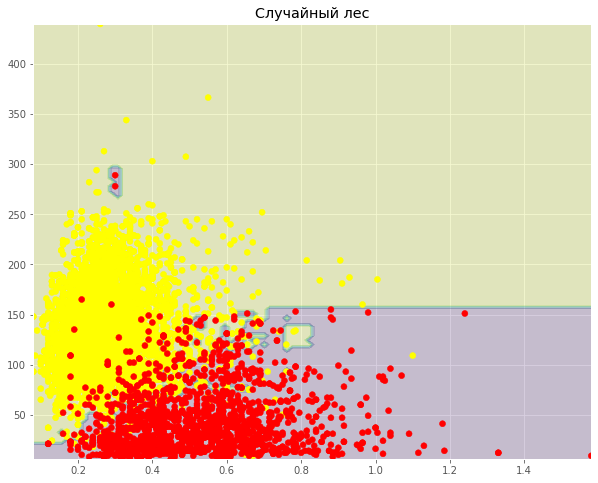

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
print(rf.score(X_test, y_test))
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

### С кросс-валидацией

TRAIN: [1300 1301 1302 ... 6494 6495 6496] TEST: [   0    1    2 ... 1297 1298 1299]
0.946923076923077
TRAIN: [   0    1    2 ... 6494 6495 6496] TEST: [1300 1301 1302 ... 2597 2598 2599]
0.9715384615384616
TRAIN: [   0    1    2 ... 6494 6495 6496] TEST: [2600 2601 2602 ... 3896 3897 3898]
0.947652040030793
TRAIN: [   0    1    2 ... 6494 6495 6496] TEST: [3899 3900 3901 ... 5195 5196 5197]
0.9322555812163202
TRAIN: [   0    1    2 ... 5195 5196 5197] TEST: [5198 5199 5200 ... 6494 6495 6496]
0.7821401077752117
0.9550561797752809


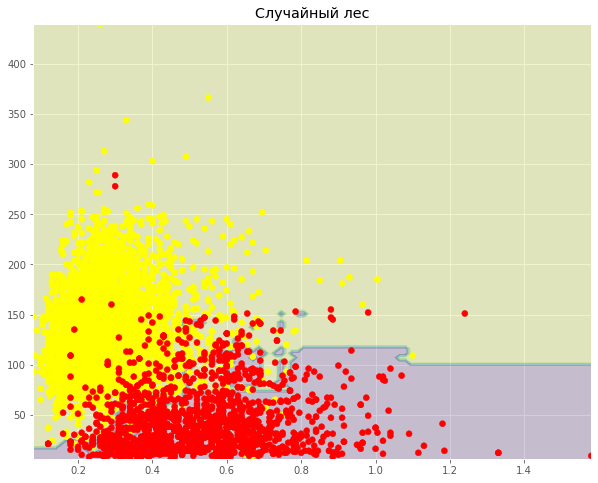

In [18]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    rf.fit(X[train_index,:], y[train_index])
    print(rf.score(X[test_index,:], y[test_index]))
print(rf.score(X, y))



x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

# Сравним качество работы и время обучения леса с градиентным бустингом над решающими деревьями, подоберем для каждого оптимальные параметры.

In [19]:
!pip install catboost

In [20]:
%%time

from sklearn.metrics import mean_squared_error
from catboost import CatBoostClassifier
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, task_type="GPU").fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

Learning rate set to 0.5
0:	learn: 0.3887626	total: 3.28ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3837195	total: 2.99ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3823379	total: 3.98ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3768434	total: 4.64ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3742112	total: 4.53ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3745923	total: 5.68ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3756775	total: 6.25ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3760816	total: 5.83ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3772655	total: 6.91ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3774835	total: 8.39ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3887626	total: 3.92ms	remaining: 43.1ms
1:	learn: 0.2724184	total: 6.26ms	remaining: 31.3ms
2:	learn: 0.2082499	total: 8.57ms	remaining: 25.7ms
3:	learn: 0.1747378	total: 10.8ms	remaining: 21.6ms
4:	learn: 0.1515459	total: 

0:	learn: 0.3837195	total: 3.44ms	remaining: 75.7ms
1:	learn: 0.2587089	total: 5.91ms	remaining: 62.1ms
2:	learn: 0.2008004	total: 8.28ms	remaining: 55.2ms
3:	learn: 0.1646736	total: 11.3ms	remaining: 53.5ms
4:	learn: 0.1421749	total: 13.6ms	remaining: 49ms
5:	learn: 0.1296300	total: 15.8ms	remaining: 44.8ms
6:	learn: 0.1245331	total: 17.9ms	remaining: 41ms
7:	learn: 0.1192765	total: 20.1ms	remaining: 37.7ms
8:	learn: 0.1160753	total: 22.3ms	remaining: 34.7ms
9:	learn: 0.1136942	total: 24.5ms	remaining: 31.9ms
10:	learn: 0.1124257	total: 27.2ms	remaining: 29.7ms
11:	learn: 0.1119911	total: 29.4ms	remaining: 26.9ms
12:	learn: 0.1116473	total: 31.6ms	remaining: 24.3ms
13:	learn: 0.1104712	total: 33.8ms	remaining: 21.7ms
14:	learn: 0.1090356	total: 36ms	remaining: 19.2ms
15:	learn: 0.1086988	total: 38.1ms	remaining: 16.7ms
16:	learn: 0.1079645	total: 40.5ms	remaining: 14.3ms
17:	learn: 0.1076824	total: 43.5ms	remaining: 12.1ms
18:	learn: 0.1075473	total: 46.4ms	remaining: 9.76ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.3772655	total: 8.3ms	remaining: 183ms
1:	learn: 0.2520410	total: 15.8ms	remaining: 166ms
2:	learn: 0.1886432	total: 22.6ms	remaining: 151ms
3:	learn: 0.1533008	total: 29.8ms	remaining: 141ms
4:	learn: 0.1348869	total: 36.8ms	remaining: 132ms
5:	learn: 0.1219089	total: 43.6ms	remaining: 123ms
6:	learn: 0.1145539	total: 50.7ms	remaining: 116ms
7:	learn: 0.1096462	total: 56.1ms	remaining: 105ms
8:	learn: 0.1065467	total: 62ms	remaining: 96.4ms
9:	learn: 0.1045896	total: 68.3ms	remaining: 88.7ms
10:	learn: 0.1034103	total: 74.2ms	remaining: 80.9ms
11:	learn: 0.1023439	total: 80.3ms	remaining: 73.6ms
12:	learn: 0.1006124	total: 86.2ms	remaining: 66.3ms
13:	learn: 0.0994404	total: 92.1ms	remaining: 59.2ms
14:	learn: 0.0985330	total: 98ms	remaining: 52.3ms
15:	learn: 0.0975794	total: 104ms	remaining: 45.4ms
16:	learn: 0.0969183	total: 109ms	remaining: 38.6ms
17:	learn: 0.0952805	total: 116ms	remaining: 32.1ms
18:	learn: 0.0943358	total: 121ms	remaining: 25

Learning rate set to 0.5
0:	learn: 0.3742112	total: 4.79ms	remaining: 158ms
1:	learn: 0.2506705	total: 8.15ms	remaining: 130ms
2:	learn: 0.1884022	total: 11.6ms	remaining: 120ms
3:	learn: 0.1536862	total: 15ms	remaining: 113ms
4:	learn: 0.1359458	total: 18.4ms	remaining: 107ms
5:	learn: 0.1251016	total: 21.7ms	remaining: 101ms
6:	learn: 0.1186995	total: 25.2ms	remaining: 97ms
7:	learn: 0.1141325	total: 28.4ms	remaining: 92.2ms
8:	learn: 0.1119397	total: 31.4ms	remaining: 87.1ms
9:	learn: 0.1100314	total: 34.4ms	remaining: 82.5ms
10:	learn: 0.1092214	total: 37.5ms	remaining: 78.5ms
11:	learn: 0.1080892	total: 40.9ms	remaining: 75ms
12:	learn: 0.1064549	total: 44.2ms	remaining: 71.4ms
13:	learn: 0.1058163	total: 47.2ms	remaining: 67.5ms
14:	learn: 0.1050399	total: 50.2ms	remaining: 63.6ms
15:	learn: 0.1042797	total: 53.3ms	remaining: 59.9ms
16:	learn: 0.1033557	total: 56.5ms	remaining: 56.5ms
17:	learn: 0.1025164	total: 59.8ms	remaining: 53.2ms
18:	learn: 0.1021866	total: 63.2ms	remainin

32:	learn: 0.0873364	total: 199ms	remaining: 6.04ms
33:	learn: 0.0868191	total: 206ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3774835	total: 8.46ms	remaining: 279ms
1:	learn: 0.2519580	total: 16.3ms	remaining: 261ms
2:	learn: 0.1883074	total: 24.3ms	remaining: 251ms
3:	learn: 0.1536376	total: 32.3ms	remaining: 242ms
4:	learn: 0.1337990	total: 39.8ms	remaining: 231ms
5:	learn: 0.1212645	total: 47.7ms	remaining: 223ms
6:	learn: 0.1145480	total: 55.4ms	remaining: 214ms
7:	learn: 0.1098710	total: 63.3ms	remaining: 206ms
8:	learn: 0.1065695	total: 71.2ms	remaining: 198ms
9:	learn: 0.1035365	total: 79.3ms	remaining: 190ms
10:	learn: 0.1016307	total: 87.7ms	remaining: 183ms
11:	learn: 0.0993113	total: 95.9ms	remaining: 176ms
12:	learn: 0.0984566	total: 104ms	remaining: 168ms
13:	learn: 0.0973254	total: 112ms	remaining: 160ms
14:	learn: 0.0962076	total: 120ms	remaining: 152ms
15:	learn: 0.0949009	total: 128ms	remaining: 144ms
16:	learn: 0.0942402	total: 136ms	remaining: 136ms
17:	l

Learning rate set to 0.497361
0:	learn: 0.3780332	total: 4ms	remaining: 176ms
1:	learn: 0.2534062	total: 6.87ms	remaining: 148ms
2:	learn: 0.1916835	total: 9.69ms	remaining: 136ms
3:	learn: 0.1560934	total: 12.7ms	remaining: 130ms
4:	learn: 0.1364843	total: 15.6ms	remaining: 125ms
5:	learn: 0.1258339	total: 18.5ms	remaining: 120ms
6:	learn: 0.1205429	total: 21.6ms	remaining: 117ms
7:	learn: 0.1153853	total: 24.5ms	remaining: 113ms
8:	learn: 0.1131587	total: 27.4ms	remaining: 109ms
9:	learn: 0.1117030	total: 30.2ms	remaining: 106ms
10:	learn: 0.1098811	total: 33.1ms	remaining: 102ms
11:	learn: 0.1085439	total: 36ms	remaining: 99ms
12:	learn: 0.1078185	total: 39.1ms	remaining: 96.2ms
13:	learn: 0.1072021	total: 41.9ms	remaining: 92.8ms
14:	learn: 0.1065839	total: 44.8ms	remaining: 89.7ms
15:	learn: 0.1059839	total: 47.6ms	remaining: 86.3ms
16:	learn: 0.1049908	total: 50.4ms	remaining: 83.1ms
17:	learn: 0.1048063	total: 53.4ms	remaining: 80.1ms
18:	learn: 0.1045630	total: 56.2ms	remaining

44:	learn: 0.0862868	total: 187ms	remaining: 0us
Learning rate set to 0.497361
0:	learn: 0.3772905	total: 7.29ms	remaining: 321ms
1:	learn: 0.2526173	total: 13.4ms	remaining: 289ms
2:	learn: 0.1894135	total: 19.8ms	remaining: 278ms
3:	learn: 0.1544686	total: 26.2ms	remaining: 268ms
4:	learn: 0.1339963	total: 32.2ms	remaining: 258ms
5:	learn: 0.1224054	total: 38.2ms	remaining: 249ms
6:	learn: 0.1159132	total: 44.7ms	remaining: 243ms
7:	learn: 0.1109685	total: 50.8ms	remaining: 235ms
8:	learn: 0.1075363	total: 57ms	remaining: 228ms
9:	learn: 0.1054625	total: 63.5ms	remaining: 222ms
10:	learn: 0.1044455	total: 69.5ms	remaining: 215ms
11:	learn: 0.1032009	total: 75.7ms	remaining: 208ms
12:	learn: 0.1021607	total: 80.7ms	remaining: 199ms
13:	learn: 0.1012344	total: 85.5ms	remaining: 189ms
14:	learn: 0.0995151	total: 90.4ms	remaining: 181ms
15:	learn: 0.0985573	total: 95.5ms	remaining: 173ms
16:	learn: 0.0973370	total: 100ms	remaining: 165ms
17:	learn: 0.0968285	total: 105ms	remaining: 158ms

Learning rate set to 0.408859
0:	learn: 0.4264074	total: 4.02ms	remaining: 221ms
1:	learn: 0.3003205	total: 7.4ms	remaining: 200ms
2:	learn: 0.2344954	total: 11.2ms	remaining: 199ms
3:	learn: 0.1904933	total: 13.8ms	remaining: 179ms
4:	learn: 0.1615382	total: 16.9ms	remaining: 172ms
5:	learn: 0.1430422	total: 19.7ms	remaining: 165ms
6:	learn: 0.1326491	total: 22.3ms	remaining: 156ms
7:	learn: 0.1259881	total: 25.5ms	remaining: 153ms
8:	learn: 0.1208207	total: 28ms	remaining: 146ms
9:	learn: 0.1169192	total: 30.6ms	remaining: 141ms
10:	learn: 0.1151770	total: 33.2ms	remaining: 136ms
11:	learn: 0.1136436	total: 35.8ms	remaining: 131ms
12:	learn: 0.1120560	total: 38.4ms	remaining: 127ms
13:	learn: 0.1113825	total: 41.5ms	remaining: 125ms
14:	learn: 0.1102714	total: 43.9ms	remaining: 120ms
15:	learn: 0.1097684	total: 46.3ms	remaining: 116ms
16:	learn: 0.1089791	total: 49ms	remaining: 112ms
17:	learn: 0.1086172	total: 51.5ms	remaining: 109ms
18:	learn: 0.1085039	total: 54ms	remaining: 105ms

Learning rate set to 0.408859
0:	learn: 0.4185067	total: 4.28ms	remaining: 235ms
1:	learn: 0.2919149	total: 8.61ms	remaining: 232ms
2:	learn: 0.2204522	total: 11.7ms	remaining: 207ms
3:	learn: 0.1799059	total: 14.7ms	remaining: 191ms
4:	learn: 0.1541781	total: 17.7ms	remaining: 181ms
5:	learn: 0.1383544	total: 20.8ms	remaining: 173ms
6:	learn: 0.1280620	total: 23.9ms	remaining: 167ms
7:	learn: 0.1211548	total: 27.3ms	remaining: 164ms
8:	learn: 0.1176287	total: 30.3ms	remaining: 158ms
9:	learn: 0.1140025	total: 33.2ms	remaining: 153ms
10:	learn: 0.1116936	total: 36.1ms	remaining: 148ms
11:	learn: 0.1099071	total: 39.3ms	remaining: 144ms
12:	learn: 0.1084083	total: 42.7ms	remaining: 141ms
13:	learn: 0.1076205	total: 46ms	remaining: 138ms
14:	learn: 0.1068554	total: 49.4ms	remaining: 135ms
15:	learn: 0.1061599	total: 52.5ms	remaining: 131ms
16:	learn: 0.1055219	total: 55.8ms	remaining: 128ms
17:	learn: 0.1050656	total: 59ms	remaining: 125ms
18:	learn: 0.1047160	total: 62.2ms	remaining: 12

Learning rate set to 0.408859
0:	learn: 0.4204668	total: 6.22ms	remaining: 342ms
1:	learn: 0.2935514	total: 10.9ms	remaining: 295ms
2:	learn: 0.2226994	total: 15.8ms	remaining: 278ms
3:	learn: 0.1805884	total: 20.5ms	remaining: 267ms
4:	learn: 0.1540038	total: 25.9ms	remaining: 264ms
5:	learn: 0.1362532	total: 31.1ms	remaining: 259ms
6:	learn: 0.1261016	total: 36ms	remaining: 252ms
7:	learn: 0.1189739	total: 41.2ms	remaining: 247ms
8:	learn: 0.1144980	total: 45.9ms	remaining: 240ms
9:	learn: 0.1107423	total: 51.6ms	remaining: 238ms
10:	learn: 0.1082471	total: 56.7ms	remaining: 232ms
11:	learn: 0.1066166	total: 61.2ms	remaining: 224ms
12:	learn: 0.1051007	total: 65.9ms	remaining: 218ms
13:	learn: 0.1040134	total: 71.3ms	remaining: 214ms
14:	learn: 0.1031363	total: 76.5ms	remaining: 209ms
15:	learn: 0.1019311	total: 81.5ms	remaining: 204ms
16:	learn: 0.1010939	total: 86.4ms	remaining: 198ms
17:	learn: 0.1006300	total: 91.6ms	remaining: 193ms
18:	learn: 0.1002047	total: 96.4ms	remaining: 

50:	learn: 0.0802995	total: 386ms	remaining: 37.9ms
51:	learn: 0.0800593	total: 394ms	remaining: 30.3ms
52:	learn: 0.0795657	total: 401ms	remaining: 22.7ms
53:	learn: 0.0792777	total: 409ms	remaining: 15.1ms
54:	learn: 0.0788680	total: 416ms	remaining: 7.56ms
55:	learn: 0.0785667	total: 423ms	remaining: 0us
Learning rate set to 0.348166
0:	learn: 0.4617376	total: 2.73ms	remaining: 180ms
1:	learn: 0.3440102	total: 4.49ms	remaining: 146ms
2:	learn: 0.2746709	total: 6.29ms	remaining: 134ms
3:	learn: 0.2262500	total: 8.1ms	remaining: 128ms
4:	learn: 0.1961938	total: 9.88ms	remaining: 123ms
5:	learn: 0.1744690	total: 11.7ms	remaining: 119ms
6:	learn: 0.1582442	total: 13.4ms	remaining: 115ms
7:	learn: 0.1472489	total: 15.4ms	remaining: 113ms
8:	learn: 0.1373685	total: 17.2ms	remaining: 111ms
9:	learn: 0.1314470	total: 19.2ms	remaining: 110ms
10:	learn: 0.1263582	total: 21.1ms	remaining: 107ms
11:	learn: 0.1230130	total: 23.1ms	remaining: 106ms
12:	learn: 0.1214563	total: 25.1ms	remaining: 10

Learning rate set to 0.348166
0:	learn: 0.4530309	total: 4.33ms	remaining: 286ms
1:	learn: 0.3279893	total: 7.65ms	remaining: 249ms
2:	learn: 0.2540404	total: 10.9ms	remaining: 233ms
3:	learn: 0.2072375	total: 14.2ms	remaining: 224ms
4:	learn: 0.1762427	total: 17.9ms	remaining: 222ms
5:	learn: 0.1553807	total: 21.1ms	remaining: 214ms
6:	learn: 0.1409731	total: 24.2ms	remaining: 208ms
7:	learn: 0.1307354	total: 27.4ms	remaining: 202ms
8:	learn: 0.1243128	total: 30.5ms	remaining: 197ms
9:	learn: 0.1196249	total: 34.3ms	remaining: 195ms
10:	learn: 0.1170115	total: 37.7ms	remaining: 192ms
11:	learn: 0.1145483	total: 40.8ms	remaining: 187ms
12:	learn: 0.1122907	total: 44ms	remaining: 183ms
13:	learn: 0.1110368	total: 47.1ms	remaining: 178ms
14:	learn: 0.1100332	total: 50.6ms	remaining: 175ms
15:	learn: 0.1090481	total: 53.9ms	remaining: 172ms
16:	learn: 0.1082179	total: 57.2ms	remaining: 168ms
17:	learn: 0.1077059	total: 60.4ms	remaining: 165ms
18:	learn: 0.1072461	total: 63.7ms	remaining: 

46:	learn: 0.0935391	total: 178ms	remaining: 75.9ms
47:	learn: 0.0931409	total: 182ms	remaining: 72ms
48:	learn: 0.0928196	total: 186ms	remaining: 68.2ms
49:	learn: 0.0926213	total: 189ms	remaining: 64.2ms
50:	learn: 0.0924499	total: 193ms	remaining: 60.4ms
51:	learn: 0.0922510	total: 196ms	remaining: 56.6ms
52:	learn: 0.0917685	total: 200ms	remaining: 52.7ms
53:	learn: 0.0915773	total: 203ms	remaining: 48.8ms
54:	learn: 0.0914285	total: 206ms	remaining: 45ms
55:	learn: 0.0912654	total: 210ms	remaining: 41.3ms
56:	learn: 0.0910885	total: 214ms	remaining: 37.5ms
57:	learn: 0.0908350	total: 217ms	remaining: 33.7ms
58:	learn: 0.0906361	total: 220ms	remaining: 29.9ms
59:	learn: 0.0903402	total: 224ms	remaining: 26.1ms
60:	learn: 0.0900489	total: 227ms	remaining: 22.4ms
61:	learn: 0.0898330	total: 231ms	remaining: 18.6ms
62:	learn: 0.0896509	total: 234ms	remaining: 14.9ms
63:	learn: 0.0894939	total: 238ms	remaining: 11.1ms
64:	learn: 0.0893768	total: 241ms	remaining: 7.43ms
65:	learn: 0.089

31:	learn: 0.0924730	total: 190ms	remaining: 207ms
32:	learn: 0.0920725	total: 196ms	remaining: 202ms
33:	learn: 0.0916973	total: 202ms	remaining: 196ms
34:	learn: 0.0914066	total: 207ms	remaining: 189ms
35:	learn: 0.0909377	total: 213ms	remaining: 184ms
36:	learn: 0.0903957	total: 219ms	remaining: 178ms
37:	learn: 0.0901425	total: 225ms	remaining: 172ms
38:	learn: 0.0897724	total: 231ms	remaining: 165ms
39:	learn: 0.0894428	total: 236ms	remaining: 159ms
40:	learn: 0.0891819	total: 242ms	remaining: 153ms
41:	learn: 0.0886487	total: 247ms	remaining: 147ms
42:	learn: 0.0881615	total: 253ms	remaining: 141ms
43:	learn: 0.0877091	total: 258ms	remaining: 135ms
44:	learn: 0.0874647	total: 264ms	remaining: 129ms
45:	learn: 0.0866111	total: 270ms	remaining: 123ms
46:	learn: 0.0861205	total: 275ms	remaining: 117ms
47:	learn: 0.0858773	total: 281ms	remaining: 111ms
48:	learn: 0.0855628	total: 286ms	remaining: 105ms
49:	learn: 0.0854019	total: 292ms	remaining: 99.4ms
50:	learn: 0.0851352	total: 29

Learning rate set to 0.303832
0:	learn: 0.4827834	total: 3.9ms	remaining: 300ms
1:	learn: 0.3649239	total: 6.88ms	remaining: 262ms
2:	learn: 0.2898116	total: 9.53ms	remaining: 238ms
3:	learn: 0.2405169	total: 11.8ms	remaining: 219ms
4:	learn: 0.2060814	total: 14.1ms	remaining: 207ms
5:	learn: 0.1797242	total: 16.4ms	remaining: 197ms
6:	learn: 0.1604928	total: 19.4ms	remaining: 197ms
7:	learn: 0.1482085	total: 21.7ms	remaining: 190ms
8:	learn: 0.1381221	total: 24.1ms	remaining: 184ms
9:	learn: 0.1312537	total: 26.7ms	remaining: 181ms
10:	learn: 0.1268433	total: 29.2ms	remaining: 178ms
11:	learn: 0.1233006	total: 31.6ms	remaining: 174ms
12:	learn: 0.1201078	total: 34.5ms	remaining: 172ms
13:	learn: 0.1175556	total: 37ms	remaining: 169ms
14:	learn: 0.1149465	total: 39.3ms	remaining: 165ms
15:	learn: 0.1137159	total: 41.9ms	remaining: 162ms
16:	learn: 0.1131078	total: 44.3ms	remaining: 159ms
17:	learn: 0.1124378	total: 46.8ms	remaining: 156ms
18:	learn: 0.1112354	total: 49.4ms	remaining: 1

62:	learn: 0.0971763	total: 184ms	remaining: 43.7ms
63:	learn: 0.0970925	total: 187ms	remaining: 40.8ms
64:	learn: 0.0969973	total: 190ms	remaining: 38ms
65:	learn: 0.0969305	total: 193ms	remaining: 35.1ms
66:	learn: 0.0967806	total: 196ms	remaining: 32.2ms
67:	learn: 0.0964710	total: 199ms	remaining: 29.2ms
68:	learn: 0.0963139	total: 201ms	remaining: 26.3ms
69:	learn: 0.0959965	total: 205ms	remaining: 23.4ms
70:	learn: 0.0958356	total: 208ms	remaining: 20.5ms
71:	learn: 0.0955688	total: 211ms	remaining: 17.6ms
72:	learn: 0.0954696	total: 214ms	remaining: 14.6ms
73:	learn: 0.0953067	total: 216ms	remaining: 11.7ms
74:	learn: 0.0951647	total: 219ms	remaining: 8.77ms
75:	learn: 0.0949718	total: 222ms	remaining: 5.85ms
76:	learn: 0.0948901	total: 225ms	remaining: 2.92ms
77:	learn: 0.0946886	total: 228ms	remaining: 0us
Learning rate set to 0.303832
0:	learn: 0.4768062	total: 4.65ms	remaining: 358ms
1:	learn: 0.3557497	total: 8.63ms	remaining: 328ms
2:	learn: 0.2789848	total: 12.6ms	remaini

Learning rate set to 0.303832
0:	learn: 0.4780926	total: 5.38ms	remaining: 414ms
1:	learn: 0.3570173	total: 10.1ms	remaining: 385ms
2:	learn: 0.2802240	total: 14.7ms	remaining: 368ms
3:	learn: 0.2292344	total: 18.9ms	remaining: 351ms
4:	learn: 0.1939418	total: 23.1ms	remaining: 337ms
5:	learn: 0.1694848	total: 27.5ms	remaining: 330ms
6:	learn: 0.1528804	total: 31.7ms	remaining: 322ms
7:	learn: 0.1405548	total: 35.9ms	remaining: 314ms
8:	learn: 0.1321052	total: 40.2ms	remaining: 308ms
9:	learn: 0.1252664	total: 44.5ms	remaining: 303ms
10:	learn: 0.1204684	total: 48.7ms	remaining: 296ms
11:	learn: 0.1173043	total: 52.7ms	remaining: 290ms
12:	learn: 0.1141839	total: 56.9ms	remaining: 285ms
13:	learn: 0.1118796	total: 61.4ms	remaining: 281ms
14:	learn: 0.1097955	total: 65.5ms	remaining: 275ms
15:	learn: 0.1083722	total: 69.7ms	remaining: 270ms
16:	learn: 0.1067841	total: 74.3ms	remaining: 267ms
17:	learn: 0.1060066	total: 78.5ms	remaining: 262ms
18:	learn: 0.1051600	total: 82.7ms	remaining

28:	learn: 0.0954130	total: 195ms	remaining: 330ms
29:	learn: 0.0952054	total: 201ms	remaining: 322ms
30:	learn: 0.0947170	total: 208ms	remaining: 315ms
31:	learn: 0.0942425	total: 214ms	remaining: 308ms
32:	learn: 0.0937627	total: 220ms	remaining: 301ms
33:	learn: 0.0933896	total: 227ms	remaining: 293ms
34:	learn: 0.0929889	total: 233ms	remaining: 286ms
35:	learn: 0.0925761	total: 239ms	remaining: 279ms
36:	learn: 0.0922796	total: 246ms	remaining: 272ms
37:	learn: 0.0919425	total: 252ms	remaining: 265ms
38:	learn: 0.0915552	total: 258ms	remaining: 258ms
39:	learn: 0.0910152	total: 264ms	remaining: 251ms
40:	learn: 0.0906632	total: 271ms	remaining: 244ms
41:	learn: 0.0903142	total: 277ms	remaining: 237ms
42:	learn: 0.0900571	total: 283ms	remaining: 230ms
43:	learn: 0.0896330	total: 289ms	remaining: 223ms
44:	learn: 0.0892625	total: 295ms	remaining: 216ms
45:	learn: 0.0890921	total: 301ms	remaining: 209ms
46:	learn: 0.0887850	total: 307ms	remaining: 203ms
47:	learn: 0.0885285	total: 314

Learning rate set to 0.269958
0:	learn: 0.5026882	total: 4.16ms	remaining: 366ms
1:	learn: 0.3889309	total: 6.3ms	remaining: 274ms
2:	learn: 0.3126705	total: 8.48ms	remaining: 243ms
3:	learn: 0.2619487	total: 10.7ms	remaining: 227ms
4:	learn: 0.2245148	total: 12.9ms	remaining: 217ms
5:	learn: 0.1961338	total: 15ms	remaining: 208ms
6:	learn: 0.1760908	total: 17.3ms	remaining: 203ms
7:	learn: 0.1601692	total: 19.8ms	remaining: 200ms
8:	learn: 0.1473072	total: 22.1ms	remaining: 196ms
9:	learn: 0.1394437	total: 24.3ms	remaining: 192ms
10:	learn: 0.1344088	total: 26.5ms	remaining: 188ms
11:	learn: 0.1284950	total: 28.7ms	remaining: 184ms
12:	learn: 0.1241202	total: 31.1ms	remaining: 182ms
13:	learn: 0.1208731	total: 33.4ms	remaining: 179ms
14:	learn: 0.1176965	total: 35.8ms	remaining: 177ms
15:	learn: 0.1156803	total: 38.4ms	remaining: 175ms
16:	learn: 0.1144795	total: 40.9ms	remaining: 173ms
17:	learn: 0.1135453	total: 43.2ms	remaining: 170ms
18:	learn: 0.1122153	total: 45.5ms	remaining: 1

0:	learn: 0.4987422	total: 3.92ms	remaining: 345ms
1:	learn: 0.3817151	total: 6.91ms	remaining: 300ms
2:	learn: 0.3044701	total: 9.86ms	remaining: 283ms
3:	learn: 0.2514981	total: 13.1ms	remaining: 279ms
4:	learn: 0.2144104	total: 16.1ms	remaining: 271ms
5:	learn: 0.1867264	total: 19.2ms	remaining: 265ms
6:	learn: 0.1680117	total: 22ms	remaining: 258ms
7:	learn: 0.1529830	total: 24.9ms	remaining: 252ms
8:	learn: 0.1425847	total: 27.9ms	remaining: 248ms
9:	learn: 0.1341276	total: 31.1ms	remaining: 246ms
10:	learn: 0.1277161	total: 34ms	remaining: 241ms
11:	learn: 0.1238814	total: 36.8ms	remaining: 236ms
12:	learn: 0.1200572	total: 39.6ms	remaining: 232ms
13:	learn: 0.1169227	total: 42.6ms	remaining: 228ms
14:	learn: 0.1156559	total: 45.6ms	remaining: 225ms
15:	learn: 0.1134580	total: 49ms	remaining: 224ms
16:	learn: 0.1119016	total: 52ms	remaining: 220ms
17:	learn: 0.1109966	total: 54.9ms	remaining: 217ms
18:	learn: 0.1098779	total: 57.8ms	remaining: 213ms
19:	learn: 0.1088018	total: 60

Learning rate set to 0.269958
0:	learn: 0.4977719	total: 4.88ms	remaining: 430ms
1:	learn: 0.3806824	total: 9.07ms	remaining: 395ms
2:	learn: 0.3038172	total: 13.3ms	remaining: 381ms
3:	learn: 0.2512424	total: 16.9ms	remaining: 359ms
4:	learn: 0.2134581	total: 20.5ms	remaining: 345ms
5:	learn: 0.1863503	total: 24.5ms	remaining: 339ms
6:	learn: 0.1663595	total: 28.2ms	remaining: 331ms
7:	learn: 0.1519794	total: 31.8ms	remaining: 322ms
8:	learn: 0.1410474	total: 35.5ms	remaining: 315ms
9:	learn: 0.1331983	total: 39.2ms	remaining: 310ms
10:	learn: 0.1268442	total: 43.1ms	remaining: 305ms
11:	learn: 0.1222915	total: 46.7ms	remaining: 300ms
12:	learn: 0.1187794	total: 50.3ms	remaining: 294ms
13:	learn: 0.1158071	total: 53.9ms	remaining: 289ms
14:	learn: 0.1137141	total: 57.6ms	remaining: 284ms
15:	learn: 0.1112954	total: 61.4ms	remaining: 280ms
16:	learn: 0.1094041	total: 65.1ms	remaining: 276ms
17:	learn: 0.1083651	total: 68.8ms	remaining: 271ms
18:	learn: 0.1073028	total: 72.8ms	remaining

80:	learn: 0.0870613	total: 363ms	remaining: 35.8ms
81:	learn: 0.0868236	total: 368ms	remaining: 31.4ms
82:	learn: 0.0866704	total: 372ms	remaining: 26.9ms
83:	learn: 0.0865166	total: 377ms	remaining: 22.4ms
84:	learn: 0.0864053	total: 381ms	remaining: 17.9ms
85:	learn: 0.0862234	total: 386ms	remaining: 13.5ms
86:	learn: 0.0860806	total: 390ms	remaining: 8.97ms
87:	learn: 0.0859003	total: 395ms	remaining: 4.48ms
88:	learn: 0.0856591	total: 399ms	remaining: 0us
Learning rate set to 0.269958
0:	learn: 0.4991018	total: 6.72ms	remaining: 591ms
1:	learn: 0.3826563	total: 11.6ms	remaining: 505ms
2:	learn: 0.3053760	total: 16.9ms	remaining: 483ms
3:	learn: 0.2515792	total: 23.5ms	remaining: 500ms
4:	learn: 0.2132614	total: 28.4ms	remaining: 476ms
5:	learn: 0.1855446	total: 33.1ms	remaining: 458ms
6:	learn: 0.1654028	total: 38.8ms	remaining: 455ms
7:	learn: 0.1501359	total: 43.7ms	remaining: 443ms
8:	learn: 0.1387693	total: 48.5ms	remaining: 431ms
9:	learn: 0.1304694	total: 54ms	remaining: 427

63:	learn: 0.0857272	total: 377ms	remaining: 147ms
64:	learn: 0.0855551	total: 383ms	remaining: 141ms
65:	learn: 0.0853181	total: 389ms	remaining: 136ms
66:	learn: 0.0849460	total: 395ms	remaining: 130ms
67:	learn: 0.0847986	total: 401ms	remaining: 124ms
68:	learn: 0.0845559	total: 408ms	remaining: 118ms
69:	learn: 0.0842233	total: 413ms	remaining: 112ms
70:	learn: 0.0839922	total: 419ms	remaining: 106ms
71:	learn: 0.0836648	total: 425ms	remaining: 100ms
72:	learn: 0.0834536	total: 430ms	remaining: 94.3ms
73:	learn: 0.0830207	total: 436ms	remaining: 88.4ms
74:	learn: 0.0827657	total: 442ms	remaining: 82.4ms
75:	learn: 0.0825376	total: 447ms	remaining: 76.5ms
76:	learn: 0.0823666	total: 453ms	remaining: 70.6ms
77:	learn: 0.0821142	total: 459ms	remaining: 64.7ms
78:	learn: 0.0818423	total: 464ms	remaining: 58.7ms
79:	learn: 0.0816059	total: 471ms	remaining: 53ms
80:	learn: 0.0814866	total: 476ms	remaining: 47ms
81:	learn: 0.0812121	total: 482ms	remaining: 41.2ms
82:	learn: 0.0810673	tota

82:	learn: 0.1062998	total: 179ms	remaining: 36.6ms
83:	learn: 0.1062449	total: 181ms	remaining: 34.5ms
84:	learn: 0.1061651	total: 183ms	remaining: 32.3ms
85:	learn: 0.1061051	total: 185ms	remaining: 30.1ms
86:	learn: 0.1060171	total: 188ms	remaining: 28ms
87:	learn: 0.1058291	total: 190ms	remaining: 25.9ms
88:	learn: 0.1057614	total: 192ms	remaining: 23.8ms
89:	learn: 0.1057084	total: 195ms	remaining: 21.6ms
90:	learn: 0.1056601	total: 197ms	remaining: 19.5ms
91:	learn: 0.1056150	total: 199ms	remaining: 17.3ms
92:	learn: 0.1055730	total: 202ms	remaining: 15.2ms
93:	learn: 0.1055338	total: 204ms	remaining: 13ms
94:	learn: 0.1054974	total: 206ms	remaining: 10.8ms
95:	learn: 0.1054787	total: 208ms	remaining: 8.65ms
96:	learn: 0.1053988	total: 210ms	remaining: 6.49ms
97:	learn: 0.1053530	total: 212ms	remaining: 4.32ms
98:	learn: 0.1052641	total: 214ms	remaining: 2.16ms
99:	learn: 0.1051881	total: 216ms	remaining: 0us
Learning rate set to 0.243192
0:	learn: 0.5190278	total: 4.17ms	remaini

65:	learn: 0.1022219	total: 177ms	remaining: 91.1ms
66:	learn: 0.1021157	total: 179ms	remaining: 88.2ms
67:	learn: 0.1020195	total: 182ms	remaining: 85.4ms
68:	learn: 0.1019193	total: 184ms	remaining: 82.6ms
69:	learn: 0.1018167	total: 186ms	remaining: 79.7ms
70:	learn: 0.1017532	total: 189ms	remaining: 77ms
71:	learn: 0.1017022	total: 192ms	remaining: 74.5ms
72:	learn: 0.1016304	total: 194ms	remaining: 71.7ms
73:	learn: 0.1014753	total: 196ms	remaining: 69ms
74:	learn: 0.1013794	total: 199ms	remaining: 66.5ms
75:	learn: 0.1013266	total: 202ms	remaining: 63.7ms
76:	learn: 0.1012577	total: 204ms	remaining: 61ms
77:	learn: 0.1011762	total: 207ms	remaining: 58.4ms
78:	learn: 0.1011195	total: 210ms	remaining: 55.8ms
79:	learn: 0.1010142	total: 212ms	remaining: 53ms
80:	learn: 0.1009649	total: 214ms	remaining: 50.3ms
81:	learn: 0.1008710	total: 217ms	remaining: 47.6ms
82:	learn: 0.1008075	total: 219ms	remaining: 44.9ms
83:	learn: 0.1006042	total: 222ms	remaining: 42.3ms
84:	learn: 0.1004743

55:	learn: 0.0984697	total: 183ms	remaining: 144ms
56:	learn: 0.0983071	total: 187ms	remaining: 141ms
57:	learn: 0.0981738	total: 190ms	remaining: 138ms
58:	learn: 0.0980374	total: 194ms	remaining: 135ms
59:	learn: 0.0978378	total: 198ms	remaining: 132ms
60:	learn: 0.0976334	total: 202ms	remaining: 129ms
61:	learn: 0.0974136	total: 206ms	remaining: 126ms
62:	learn: 0.0972958	total: 209ms	remaining: 123ms
63:	learn: 0.0971363	total: 213ms	remaining: 120ms
64:	learn: 0.0970213	total: 216ms	remaining: 116ms
65:	learn: 0.0968968	total: 219ms	remaining: 113ms
66:	learn: 0.0967622	total: 222ms	remaining: 109ms
67:	learn: 0.0966600	total: 225ms	remaining: 106ms
68:	learn: 0.0964581	total: 228ms	remaining: 103ms
69:	learn: 0.0961814	total: 232ms	remaining: 99.3ms
70:	learn: 0.0960961	total: 235ms	remaining: 95.8ms
71:	learn: 0.0959583	total: 237ms	remaining: 92.4ms
72:	learn: 0.0958405	total: 240ms	remaining: 88.9ms
73:	learn: 0.0955629	total: 243ms	remaining: 85.5ms
74:	learn: 0.0954182	total

41:	learn: 0.0968390	total: 180ms	remaining: 248ms
42:	learn: 0.0964801	total: 184ms	remaining: 244ms
43:	learn: 0.0962581	total: 189ms	remaining: 240ms
44:	learn: 0.0959971	total: 193ms	remaining: 236ms
45:	learn: 0.0956283	total: 197ms	remaining: 231ms
46:	learn: 0.0954093	total: 201ms	remaining: 227ms
47:	learn: 0.0952037	total: 205ms	remaining: 223ms
48:	learn: 0.0949183	total: 209ms	remaining: 218ms
49:	learn: 0.0946901	total: 213ms	remaining: 213ms
50:	learn: 0.0945082	total: 217ms	remaining: 209ms
51:	learn: 0.0942722	total: 221ms	remaining: 204ms
52:	learn: 0.0938226	total: 225ms	remaining: 200ms
53:	learn: 0.0936271	total: 229ms	remaining: 195ms
54:	learn: 0.0932513	total: 233ms	remaining: 191ms
55:	learn: 0.0930312	total: 237ms	remaining: 186ms
56:	learn: 0.0928473	total: 241ms	remaining: 182ms
57:	learn: 0.0926564	total: 245ms	remaining: 177ms
58:	learn: 0.0924684	total: 249ms	remaining: 173ms
59:	learn: 0.0921857	total: 253ms	remaining: 169ms
60:	learn: 0.0918308	total: 257

33:	learn: 0.0973508	total: 200ms	remaining: 388ms
34:	learn: 0.0969918	total: 206ms	remaining: 382ms
35:	learn: 0.0966056	total: 213ms	remaining: 378ms
36:	learn: 0.0962938	total: 219ms	remaining: 372ms
37:	learn: 0.0959454	total: 225ms	remaining: 367ms
38:	learn: 0.0956145	total: 230ms	remaining: 360ms
39:	learn: 0.0948174	total: 236ms	remaining: 353ms
40:	learn: 0.0945146	total: 242ms	remaining: 348ms
41:	learn: 0.0941424	total: 247ms	remaining: 341ms
42:	learn: 0.0939055	total: 253ms	remaining: 335ms
43:	learn: 0.0936312	total: 258ms	remaining: 329ms
44:	learn: 0.0934145	total: 264ms	remaining: 323ms
45:	learn: 0.0929815	total: 270ms	remaining: 316ms
46:	learn: 0.0926416	total: 275ms	remaining: 311ms
47:	learn: 0.0922212	total: 281ms	remaining: 304ms
48:	learn: 0.0918219	total: 287ms	remaining: 299ms
49:	learn: 0.0916399	total: 293ms	remaining: 293ms
50:	learn: 0.0914372	total: 298ms	remaining: 287ms
51:	learn: 0.0912313	total: 304ms	remaining: 281ms
52:	learn: 0.0910192	total: 310

93:	learn: 0.0786128	total: 768ms	remaining: 49ms
94:	learn: 0.0784443	total: 777ms	remaining: 40.9ms
95:	learn: 0.0783116	total: 785ms	remaining: 32.7ms
96:	learn: 0.0781310	total: 794ms	remaining: 24.6ms
97:	learn: 0.0779333	total: 802ms	remaining: 16.4ms
98:	learn: 0.0777863	total: 810ms	remaining: 8.18ms
99:	learn: 0.0774954	total: 818ms	remaining: 0us
Wall time: 53.3 s


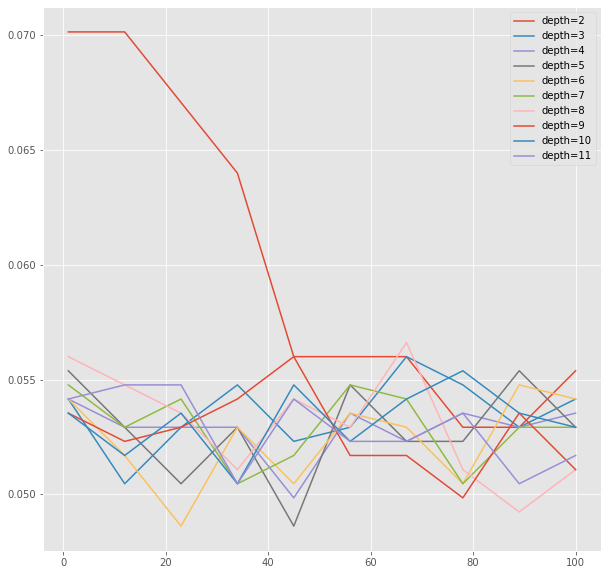

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.legend()

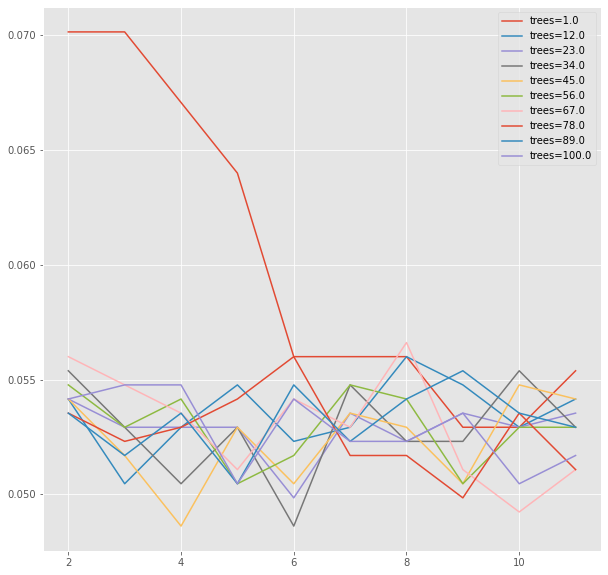

In [22]:
plt.figure(figsize=(10,10))
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.legend()

In [23]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor().fit(X_train, y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.2003140254622018
Wall time: 295 ms
